# Predição de séries temporais utilizando redes neurais recorrentes simples,  LSTM, GRU e CNN1D


Aqui desenvolveremos duas redes neurais recorrentes, dos tipos simples, LSTM, GRU e CNN1D, utilizando o Keras, para demonstrar sua capacidade em prever séries temporais


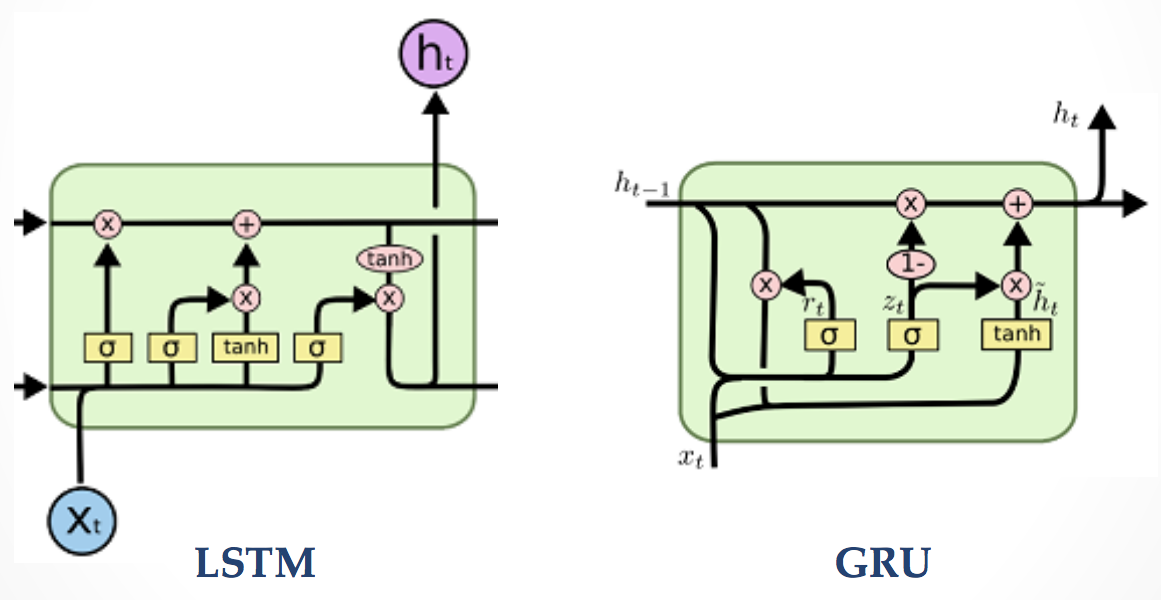

### Alguns imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, MaxPooling3D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Para garantir que nossos resultados sejam reprodutíveis, vamos fixar a semente de aleatorização (random seed) 

In [ ]:
# fixa random seed para garantir reprodutibilidade
np.random.seed(0)
tensorflow.random.set_seed(0)

## Carregando os dados

O dataset a ser utilizado é a produção de $CO_2$ em partes por milhão (ppm) do vulcão Mauna Loa
(https://en.wikipedia.org/wiki/Mauna_Loa) entre 1965-1980 por mês. 

Os dados serão carregados utilizando o Pandas. Não estamos interessados no campo "data", uma vez que cada observação está separada pelo mesmo intervalo de um mês. Assim, ao carregarmos os dados podemos excluir a primeira coluna. 

O arquivo CSV possui a informação no rodapé que pode ser também excluída (argumento pandas.read_csv() configurado para 3 para as últimas 3 linhas). 

In [2]:
# carrega o dataset
df = pd.read_csv('https://drive.google.com/uc?export=view&id=1p1d4sUN5aFsRe45kCn4NPjJ4SZ2nFlS4', usecols=[1], engine='python', skipfooter=3)
# pega os valores como np.array
data = df.values
data = data.astype('float32')
print('Quantidade de dados no arquivo:',len(data))

Quantidade de dados no arquivo: 192


In [3]:
df

,"CO2 (ppm) mauna loa, 1965-1980"
0,319.32
1,320.36
2,320.82
3,322.06
4,322.17
...,...
187,337.19
188,335.49
189,336.63
190,337.74


## Visualizando os dados

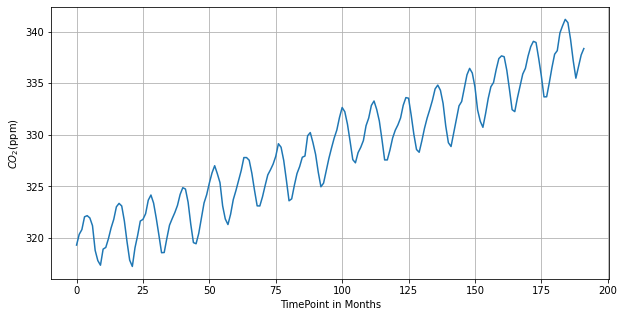

In [ ]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);

Em séries temporais, a sequência dos dados é importante. Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste. 


In [ ]:
# split into train and test sets
train_size = int(len(data) * 0.7)
# python =D
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Dataset de treinamento contém: ', len(train),' dados')
print('Dataset de teste contém: ', len(test),' dados')
data.shape

Dataset de treinamento contém:  134  dados
Dataset de teste contém:  58  dados


(192, 1)

Os LSTMs são sensíveis à escala dos dados de entrada, especificamente quando as funções de ativação sigmóide ou tanh são usadas. É fundamental normalizar os dados para o intervalo de [0, 1]. Isso pode ser feito usando a classe de pré-processamento MinMaxScaler da biblioteca scikit-learn.

### Problema 1

Use o MinMaxScaler para normalizar o conjunto de treinamento e testes entre 0 e 1. 

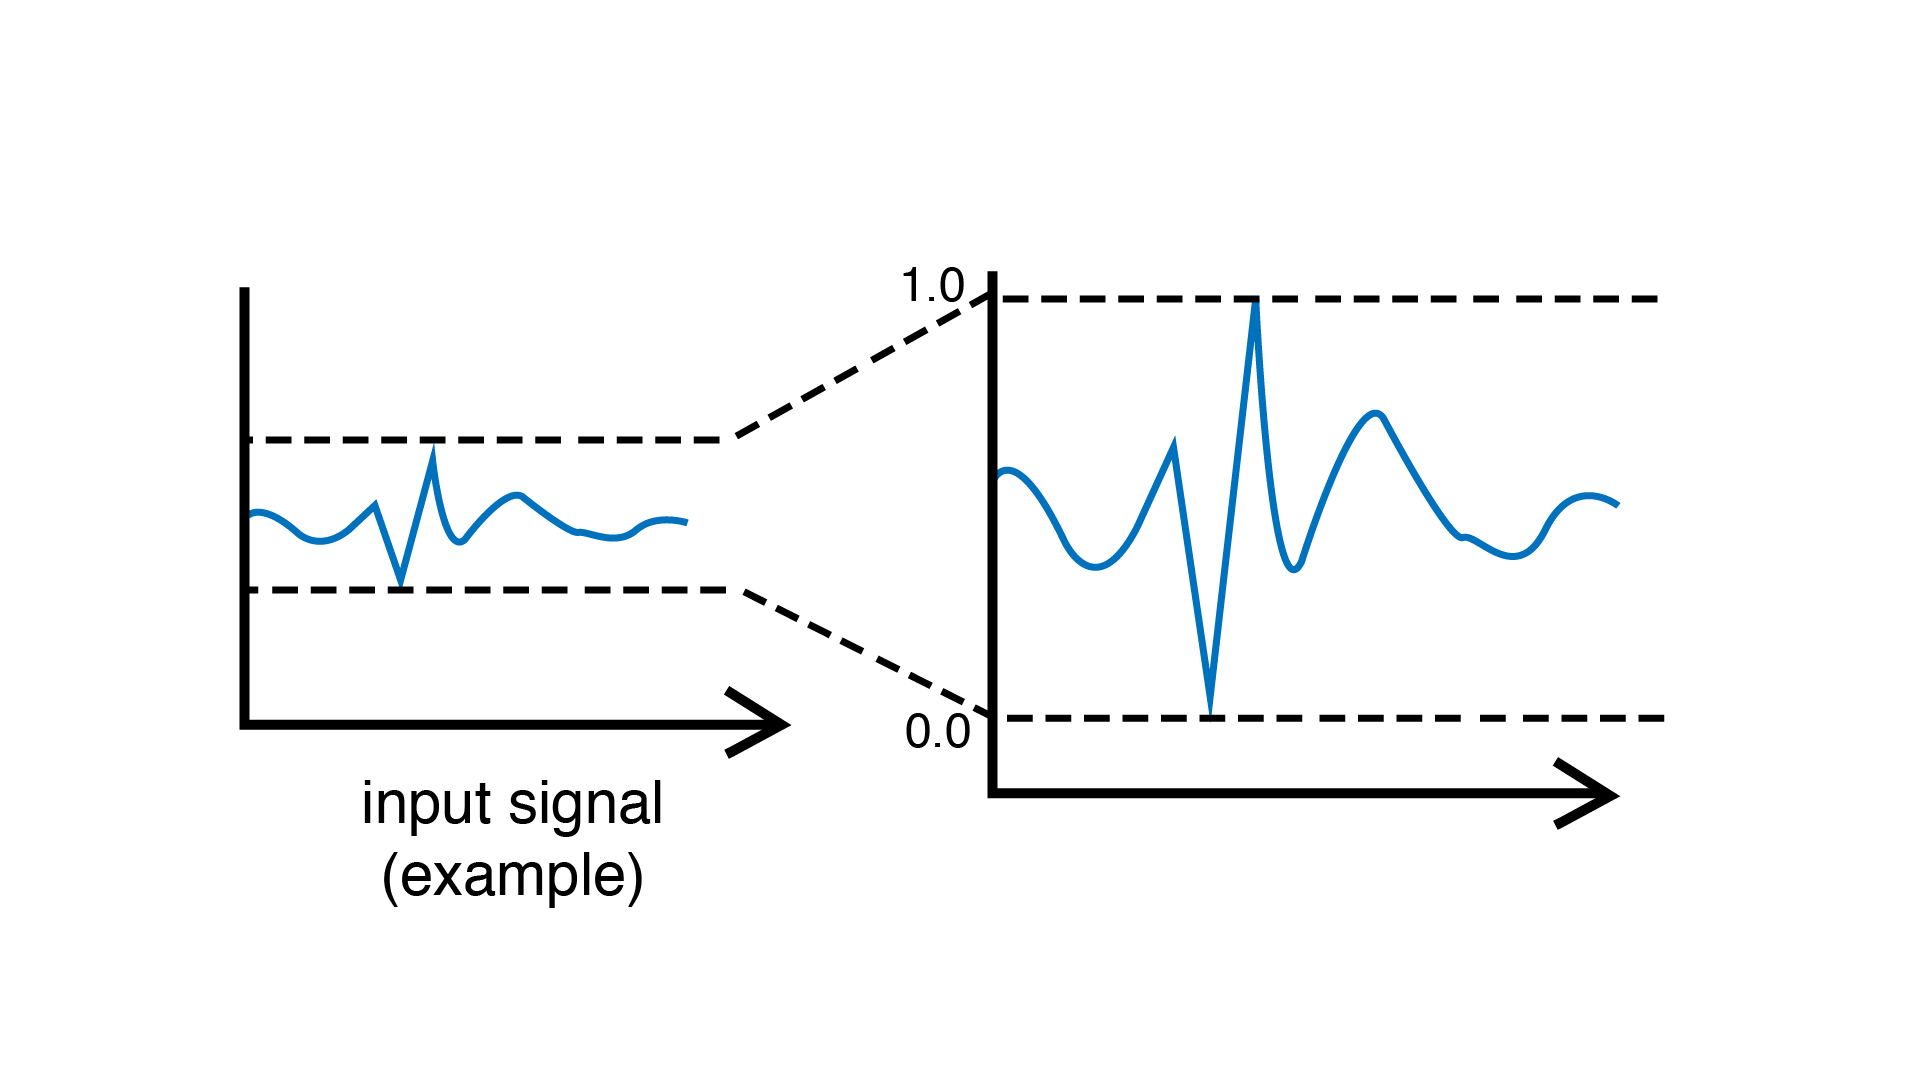

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# normalize the dataset
data_train = scaler.fit_transform(data)
norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

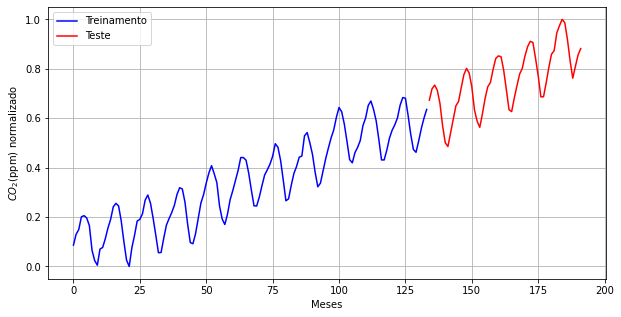

In [ ]:
plt.figure(figsize=[10,5])
plt.xlabel('Meses')
plt.ylabel('$CO_2$(ppm) normalizado')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Treinamento','Teste']);

### Problema 2

Podemos escrever uma função que separa os dados em um array de entrada (X) que tenha todo o dado no tempo t-i, e um array de saída que contenha os dados no momento t.

A função usa dois argumentos: os dados e o look_back, que é o número de timesteps anteriores a serem usados como variáveis de entrada para prever o próximo período de tempo - o padrão é 1.

In [ ]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

In [ ]:
a = np.array([[a] for a in range(10)])
a

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [ ]:
aa, bb = split_X_y(a,3)
for x,y in zip(aa, bb):
    print(x, y)

[0 1 2] [3]
[1 2 3] [4]
[2 3 4] [5]
[3 4 5] [6]
[4 5 6] [7]
[5 6 7] [8]
[6 7 8] [9]


In [ ]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 1 # olha somente para a amostra anterior para prever a próxima amostra


In [ ]:
norm_train.shape

(134, 1)

A RNN simples espera que os dados de entrada (X) sejam fornecidos na forma de: [sample, time steps, features].

Atualmente, os dados estão no formato: [samples, features], e estamos modelando o problema como um timestep para cada amostra. Usando numpy.reshape() da seguinte forma fazemos a devida transformação:

In [ ]:
# # reshape a entrada para [samples, time steps, features]
def reshape_train_test(look_back, split_size):
    trainX_whole, trainY_whole = split_X_y(norm_train, look_back)
    testX, testY = split_X_y(norm_test, look_back)
    trainX_whole = np.reshape(trainX_whole, (trainX_whole.shape[0], look_back, data.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], look_back, data.shape[1]))

    # cria o dataset de validação
    trainX, valX, trainY, valY = train_test_split(trainX_whole, trainY_whole, test_size=split_size)
    return trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY

In [ ]:
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.3)

print('Shape de trainX_whole', trainX_whole.shape)
print('Shape de x_train', trainX.shape)
print('Shape de x_val', valX.shape)
print('Shape de x_test', testX.shape)

print('Shape de trainY_whole', trainY_whole.shape)
print('Shape de y_train', trainY.shape)
print('Shape de y_val', valY.shape)
print('Shape de y_test', testY.shape)

Shape de trainX_whole (133, 1, 1)
Shape de x_train (93, 1, 1)
Shape de x_val (40, 1, 1)
Shape de x_test (57, 1, 1)
Shape de trainY_whole (133, 1)
Shape de y_train (93, 1)
Shape de y_val (40, 1)
Shape de y_test (57, 1)


Vamos agora projetar e ajustar nossa RNN simples.

A rede tem uma camada visível com 1 entrada, uma camada oculta com 4 blocos recorrentes ou neurônios e uma camada de saída que faz uma previsão de valor único. A função de ativação sigmóide padrão é usada para os blocos recorrentes. A rede é treinada por 20 épocas e um tamanho de lote de 1 é usado.

### Rede RNN simples

In [ ]:
# cria e ajusta a RNN simples 
K.clear_session()
model = Sequential()
model.add(SimpleRNN(4, activation='linear', input_shape=(look_back,data.shape[1])))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 24        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam',
                    metrics=["MAE", "MSE"])

history = model.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
93/93 [==============================] - 1s 4ms/step - loss: 0.2994 - MAE: 0.4661 - MSE: 0.2994 - val_loss: 0.1891 - val_MAE: 0.3652 - val_MSE: 0.1891
Epoch 2/20
93/93 [==============================] - 0s 2ms/step - loss: 0.1040 - MAE: 0.2594 - MSE: 0.1040 - val_loss: 0.0686 - val_MAE: 0.2149 - val_MSE: 0.0686
Epoch 3/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0513 - MAE: 0.1909 - MSE: 0.0513 - val_loss: 0.0417 - val_MAE: 0.1686 - val_MSE: 0.0417
Epoch 4/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0415 - MAE: 0.1772 - MSE: 0.0415 - val_loss: 0.0362 - val_MAE: 0.1568 - val_MSE: 0.0362
Epoch 5/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0371 - MAE: 0.1675 - MSE: 0.0371 - val_loss: 0.0320 - val_MAE: 0.1476 - val_MSE: 0.0320
Epoch 6/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0329 - MAE: 0.1565 - MSE: 0.0329 - val_loss: 0.0281 - val_MAE: 0.1383 - val_MSE: 0.0281
Epoch 7/20
93/93 [==========

Vamos agora definir uma função para fazer as previsões e plotar. 
Uma vez que o modelo estiver ajustado, podemos estimar o desempenho do modelo nos conjuntos de dados de treinamento e teste.

Observe que devemos inverter (desnormalizar) as previsões antes de calcular a acurácia para garantir que o desempenho seja comparado nas mesmas unidades que os dados originais (ppm por mês).

As previsões foram geradas usando o modelo para o conjunto de dados de treinamento e de teste. Também podemos visualizar os resultados para ter uma indicação de como o modelo funciona.

Ao plotar os dados, devemos deslocar as previsões pelo look_back no tempo para alinhar no eixo x com o conjunto de dados original. Os dados são apresentados com o conjunto de dados original como pontos pretos, as previsões para o conjunto de dados de treinamento em azul e as previsões no conjunto de dados de teste em vermelho.

In [ ]:
def plot_history_predictions(history, Xtrain, Ytrain, Xtest, Ytest, scaler, model, title, xlabel, ylabel, lookback):
    # Resumo do historico de loss
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
    plt.show()

    # faz as predições
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xtest)

    # inverte as predições
    if(len(trainPredict.shape)==3):
        trainPredict=trainPredict[:,-1,:]
        testPredict=testPredict[:,-1,:]
    trainPredict = scaler.inverse_transform(trainPredict)
    trainYTrue = scaler.inverse_transform(Ytrain)
    testPredict = scaler.inverse_transform(testPredict)
    testYTrue = scaler.inverse_transform(Ytest)

    # calcula o root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
    print('Treinamento: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
    print('Teste: %.2f RMSE' % (testScore))

    plt.figure(figsize=[10,5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(range(len(data)),data,'k.')
    plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
    plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
    plt.legend(['Original','Treinamento','Teste']);
    

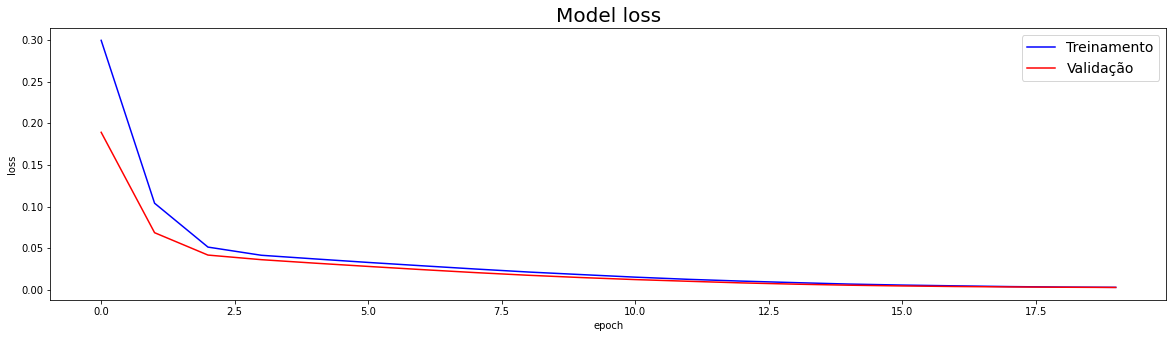

Treinamento: 1.26 RMSE
Teste: 1.89 RMSE


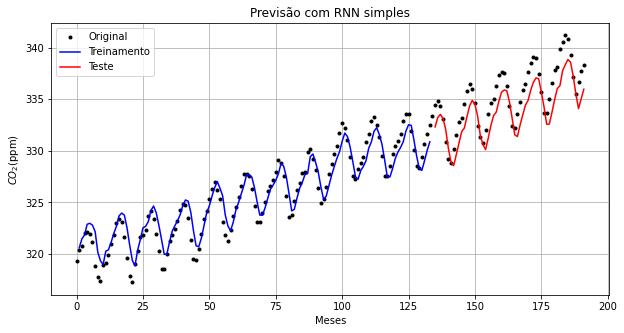

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, model, 
                         'Previsão com RNN simples', 'Meses', '$CO_2$(ppm)', look_back)

### Rede LSTM

Vamos agora projetar e ajustar nossa rede LSTM.


In [ ]:
# cria e ajusta a rede LSTM 
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back, data.shape[1])))
modelLSTM.add(Dense(1, activation='linear'))

modelLSTM.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
93/93 [==============================] - 1s 4ms/step - loss: 0.1410 - val_loss: 0.1081
Epoch 2/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0615
Epoch 3/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0370
Epoch 4/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0281
Epoch 5/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 6/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0218
Epoch 7/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 8/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0184
Epoch 9/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0196 - val_loss: 0.0168
Epoch 10/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0153
Epoch 11/20
93/93 [

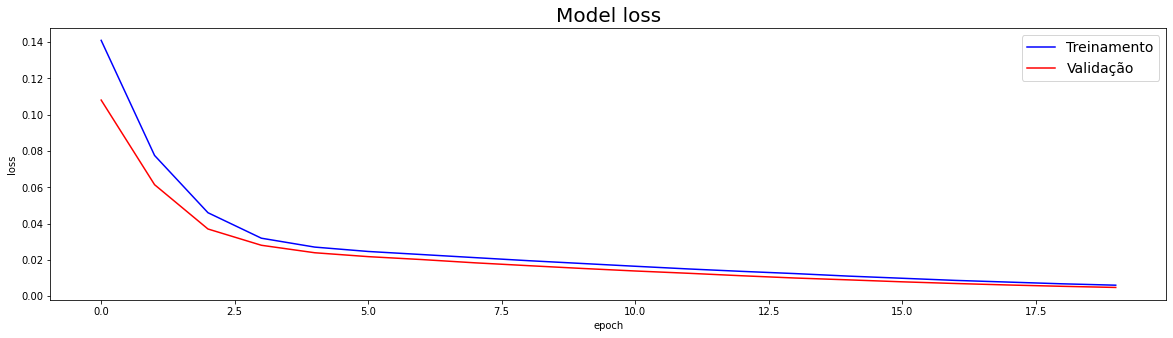

Treinamento: 1.75 RMSE
Teste: 2.77 RMSE


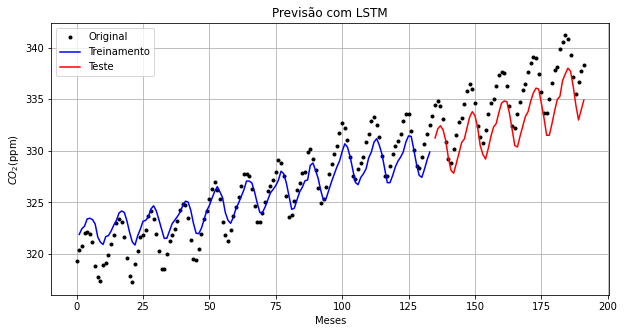

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 3

Melhore os resultados acima tentando o seguinte:
- Aumentar o número de épocas
- Aumentar o valor look_back
- Modificar a arquitetura
- Outros...

Como exemplo, use look_back de 5, aumente o tamanho do dataset de treinamento, aumente o número de épocas e adicione uma camada de dropout


In [ ]:
look_back = TODO # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.3)


In [ ]:
del modelLSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back, data.shape[1])), sequ)
modelLSTM.add(LSTM(4, activation='linear'))
modelLSTM.add(Dense(1))



In [ ]:
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')
history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 4 - Rede GRU

Utilizar outro modelo, a GRU (Gated Recurrent Units)


In [ ]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 5 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.3)

In [ ]:
modelGRU = Sequential()
modelGRU.add(GRU(4, input_shape=(look_back, data.shape[1])))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1, activation='linear'))


In [ ]:
modelGRU.compile(loss='mean_squared_error', optimizer='adam')
history = modelGRU.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
93/93 [==============================] - 2s 6ms/step - loss: 0.0942 - val_loss: 0.0527
Epoch 2/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0244
Epoch 3/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0207
Epoch 4/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0205
Epoch 5/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0178
Epoch 6/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0162
Epoch 7/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0147
Epoch 8/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0132
Epoch 9/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0184 - val_loss: 0.0120
Epoch 10/20
93/93 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0109
Epoch 11/20
93/93 [

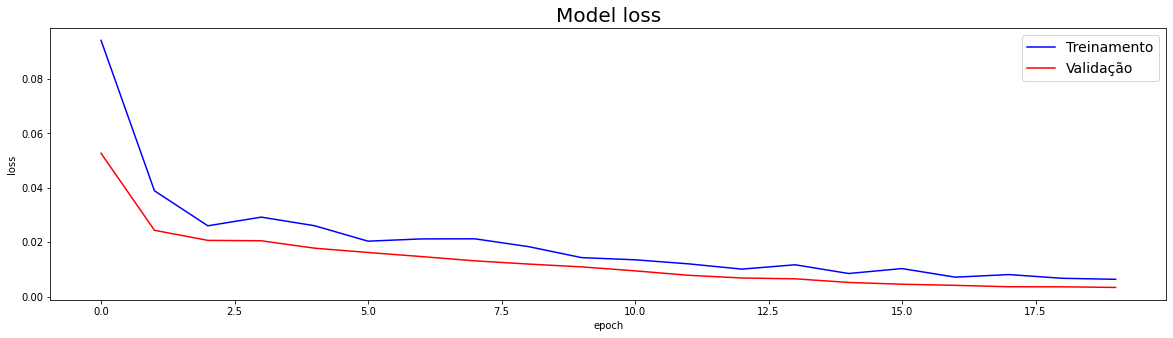

Treinamento: 1.42 RMSE
Teste: 2.94 RMSE


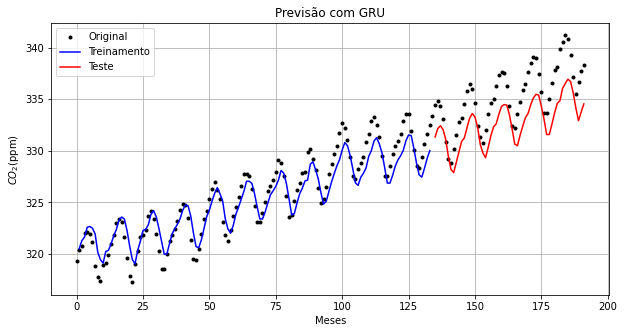

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelGRU, 
                         'Previsão com GRU', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 5 - Rede CNN1D

Utilizar outro modelo, a CNN1D


In [ ]:
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh'))
modelCNN1D.add(MaxPooling1D(pool_size=1))
modelCNN1D.add(Dropout(0.2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(10, activation='tanh'))
modelCNN1D.add(Dense(1, activation='linear'))

modelCNN1D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1D.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
3/3 [==============================] - 1s 79ms/step - loss: 0.4649 - mse: 0.2898 - val_loss: 0.3138 - val_mse: 0.1332
Epoch 2/20
3/3 [==============================] - 0s 12ms/step - loss: 0.2310 - mse: 0.0895 - val_loss: 0.1016 - val_mse: 0.0153
Epoch 3/20
3/3 [==============================] - 0s 12ms/step - loss: 0.1061 - mse: 0.0188 - val_loss: 0.1265 - val_mse: 0.0196
Epoch 4/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1449 - mse: 0.0278 - val_loss: 0.1444 - val_mse: 0.0237
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1306 - mse: 0.0229 - val_loss: 0.0708 - val_mse: 0.0077
Epoch 6/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0924 - mse: 0.0126 - val_loss: 0.0708 - val_mse: 0.0075
Epoch 7/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0923 - mse: 0.0143 - val_loss: 0.0960 - val_mse: 0.0135
Epoch 8/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0945 - mse: 0.0153 - val

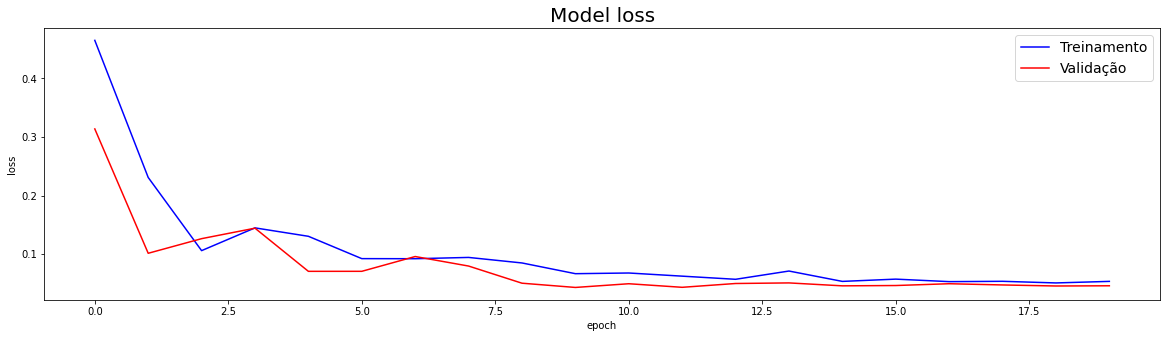

Treinamento: 1.15 RMSE
Teste: 1.48 RMSE


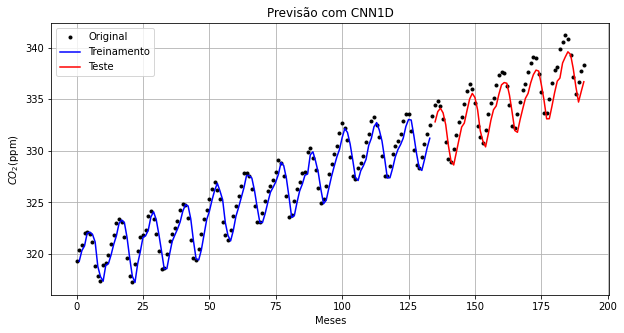

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1D, 
                         'Previsão com CNN1D', 'Meses', '$CO_2$(ppm)', look_back)


### Problema 6


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes.
Nesta primeira parte, vamos criar uma rede que combina operações de convolução, para depois enviar as principais características retornadas para uma camada LSTM. Esta abordagem é chamada muitas vezes de CNN-LSTM, FCN-LSTM ou FC-LSTM.


In [ ]:
modelCNN1DLSTM = Sequential()
modelCNN1DLSTM.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTM.add(MaxPooling1D(pool_size=1))

modelCNN1DLSTM.add(LSTM(16))
modelCNN1DLSTM.add(Dropout(0.2))

modelCNN1DLSTM.add(Flatten())

modelCNN1DLSTM.add(Dense(10, activation='tanh'))
modelCNN1DLSTM.add(Dense(1, activation='linear'))

modelCNN1DLSTM.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 128)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1DLSTM.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1DLSTM.fit(trainX, trainY, epochs=epochs, verbose=verbose, 
                             validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
3/3 [==============================] - 2s 225ms/step - loss: 0.2942 - mse: 0.1118 - val_loss: 0.2687 - val_mse: 0.0929
Epoch 2/20
3/3 [==============================] - 0s 13ms/step - loss: 0.2422 - mse: 0.0795 - val_loss: 0.2084 - val_mse: 0.0587
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1812 - mse: 0.0477 - val_loss: 0.1472 - val_mse: 0.0313
Epoch 4/20
3/3 [==============================] - 0s 20ms/step - loss: 0.1338 - mse: 0.0271 - val_loss: 0.0938 - val_mse: 0.0130
Epoch 5/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0892 - mse: 0.0124 - val_loss: 0.0654 - val_mse: 0.0066
Epoch 6/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0882 - mse: 0.0115 - val_loss: 0.0815 - val_mse: 0.0099
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1025 - mse: 0.0144 - val_loss: 0.0945 - val_mse: 0.0125
Epoch 8/20
3/3 [==============================] - 0s 17ms/step - loss: 0.1065 - mse: 0.0147 - va

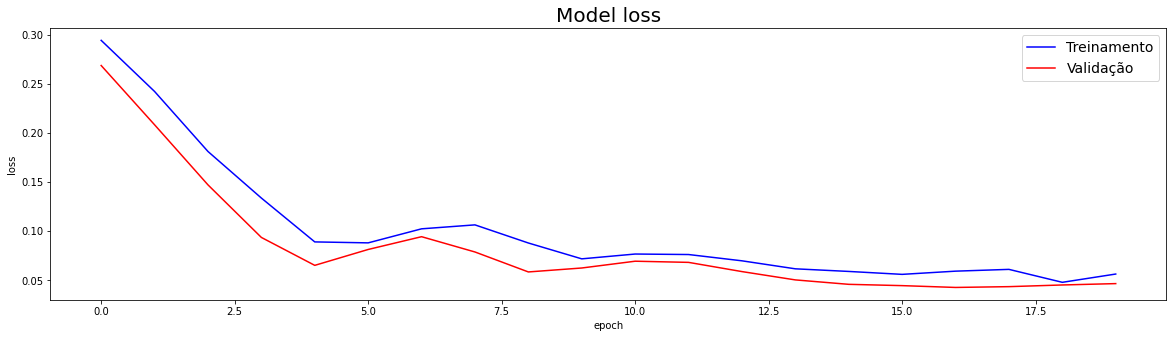

Treinamento: 1.25 RMSE
Teste: 1.80 RMSE


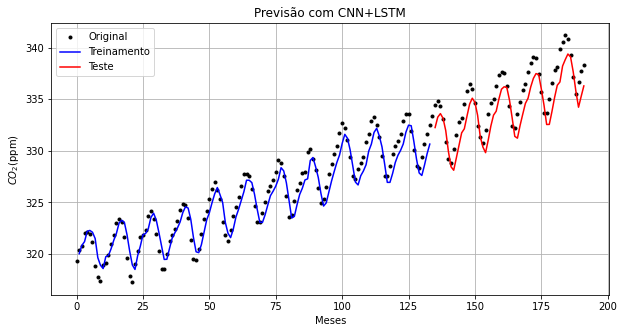

In [ ]:
plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTM, 
                         'Previsão com CNN+LSTM', 'Meses', '$CO_2$(ppm)', look_back)

### Problema 7


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes: a Conv2DLSTM


In [ ]:
trainX.shape


(93, 1, 1)

In [ ]:
trainX2D = trainX.reshape((trainX.shape[0], trainX.shape[1], 1, trainX.shape[2], 1))
valX2D = valX.reshape((valX.shape[0], valX.shape[1], 1, valX.shape[2], 1))
trainX2D.shape

(93, 1, 1, 1, 1)

In [ ]:
modelConvLSTM2D = Sequential()

modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True,
                           input_shape=(look_back, trainX2D.shape[2], trainX2D.shape[3], trainX2D.shape[4])))
modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True))
modelConvLSTM2D.add(MaxPooling3D(pool_size=(look_back,1,1)))
modelConvLSTM2D.add(Dropout(0.2))
modelConvLSTM2D.add(Flatten())
modelConvLSTM2D.add(Dense(10, activation='tanh'))
modelConvLSTM2D.add(Dense(1, activation='linear'))


In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelConvLSTM2D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelConvLSTM2D.fit(trainX2D, trainY, epochs=epochs, verbose=verbose, validation_data=(valX2D, valY), 
                              batch_size=batch_size)

Epoch 1/20
3/3 [==============================] - 5s 246ms/step - loss: 0.3260 - mse: 0.1369 - val_loss: 0.3156 - val_mse: 0.1272
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2867 - mse: 0.1096 - val_loss: 0.2708 - val_mse: 0.0984
Epoch 3/20
3/3 [==============================] - 0s 18ms/step - loss: 0.2453 - mse: 0.0840 - val_loss: 0.2244 - val_mse: 0.0704
Epoch 4/20
3/3 [==============================] - 0s 18ms/step - loss: 0.1978 - mse: 0.0580 - val_loss: 0.1746 - val_mse: 0.0447
Epoch 5/20
3/3 [==============================] - 0s 18ms/step - loss: 0.1549 - mse: 0.0364 - val_loss: 0.1307 - val_mse: 0.0250
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 0.1236 - mse: 0.0212 - val_loss: 0.1028 - val_mse: 0.0155
Epoch 7/20
3/3 [==============================] - 0s 20ms/step - loss: 0.1137 - mse: 0.0178 - val_loss: 0.1049 - val_mse: 0.0171
Epoch 8/20
3/3 [==============================] - 0s 19ms/step - loss: 0.1178 - mse: 0.0206 - va

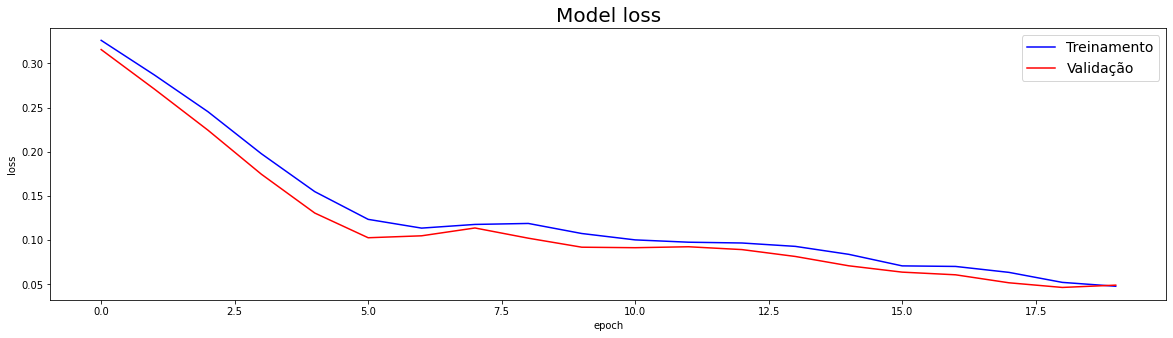

Treinamento: 1.37 RMSE
Teste: 2.39 RMSE


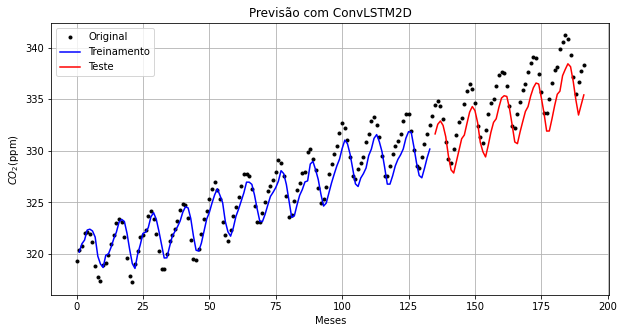

In [ ]:
trainX2D_whole = trainX_whole.reshape((trainX_whole.shape[0], trainX_whole.shape[1], 1, trainX_whole.shape[2], 1))
testX2D = testX.reshape((testX.shape[0], testX.shape[1], 1, testX.shape[2], 1))


plot_history_predictions(history, trainX2D_whole, trainY_whole, testX2D, testY, scaler, modelConvLSTM2D, 
                         'Previsão com ConvLSTM2D', 'Meses', '$CO_2$(ppm)', look_back)

### Problema 8


Vamos aprender a utilizar a camada TimeDistributed <p>
Para tal, vamos configurar uma rede sem, e outra com, a camada TimeDistributed, e vamos comparar o desempenho de ambas.
    
Fonte: https://keras.io/api/layers/recurrent_layers/time_distributed/


In [ ]:
#Rede FCN+LSTM sem TimeDistributed
modelCNN1DLSTMSemTD = Sequential()
modelCNN1DLSTMSemTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMSemTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMSemTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMSemTD.add(Dense(10, activation='tanh'))
modelCNN1DLSTMSemTD.add(Dense(1, activation='linear'))

modelCNN1DLSTMSemTD.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 128)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             9280      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 10)             170       
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              11        
Total params: 9,717
Trainable params: 9,717
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Rede FCN+LSTM com TimeDistributed
modelCNN1DLSTMTD = Sequential()
modelCNN1DLSTMTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(10, activation='tanh')))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(1, activation='linear')))

modelCNN1DLSTMTD.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 128)            256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             9280      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 10)             170       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              11        
Total params: 9,717
Trainable params: 9,717
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

#treinando a rede sem TimeDistributed
modelCNN1DLSTMSemTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historySemTD = modelCNN1DLSTMSemTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
3/3 [==============================] - 2s 242ms/step - loss: 0.3044 - mse: 0.1194 - val_loss: 0.2663 - val_mse: 0.0928
Epoch 2/20
3/3 [==============================] - 0s 13ms/step - loss: 0.2321 - mse: 0.0740 - val_loss: 0.1911 - val_mse: 0.0507
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1619 - mse: 0.0389 - val_loss: 0.1204 - val_mse: 0.0215
Epoch 4/20
3/3 [==============================] - 0s 18ms/step - loss: 0.1034 - mse: 0.0163 - val_loss: 0.0745 - val_mse: 0.0082
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0788 - mse: 0.0089 - val_loss: 0.0849 - val_mse: 0.0107
Epoch 6/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0937 - mse: 0.0129 - val_loss: 0.0991 - val_mse: 0.0137
Epoch 7/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0945 - mse: 0.0130 - val_loss: 0.0794 - val_mse: 0.0095
Epoch 8/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0763 - mse: 0.0087 - va

In [ ]:
# treinando a rede com TimeDistributed
modelCNN1DLSTMTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyTD = modelCNN1DLSTMTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
3/3 [==============================] - 2s 233ms/step - loss: 0.2990 - mse: 0.1153 - val_loss: 0.2747 - val_mse: 0.0974
Epoch 2/20
3/3 [==============================] - 0s 13ms/step - loss: 0.2466 - mse: 0.0826 - val_loss: 0.2173 - val_mse: 0.0642
Epoch 3/20
3/3 [==============================] - 0s 12ms/step - loss: 0.1899 - mse: 0.0520 - val_loss: 0.1609 - val_mse: 0.0372
Epoch 4/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1373 - mse: 0.0286 - val_loss: 0.1100 - val_mse: 0.0180
Epoch 5/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0975 - mse: 0.0145 - val_loss: 0.0768 - val_mse: 0.0088
Epoch 6/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0771 - mse: 0.0087 - val_loss: 0.0784 - val_mse: 0.0095
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0880 - mse: 0.0114 - val_loss: 0.0940 - val_mse: 0.0126
Epoch 8/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0938 - mse: 0.0129 - va

In [ ]:
#vamos ver o shape retornado do predict da rede com e sem TimeDistributed
tsTD=modelCNN1DLSTMSemTD.predict(testX);
print(tsTD.shape, len(tsTD.shape))

tTD=modelCNN1DLSTMTD.predict(testX);
print(tTD.shape, len(tTD.shape))


(57, 1, 1) 3
(57, 1, 1) 3


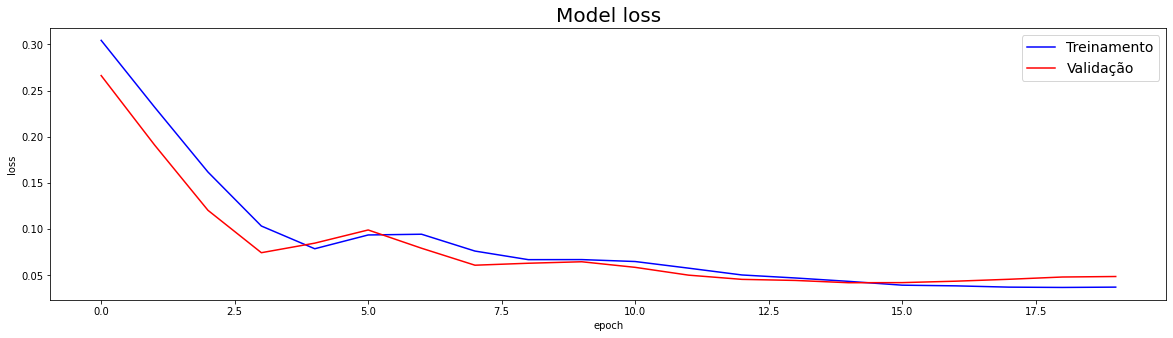

Treinamento: 1.25 RMSE
Teste: 1.94 RMSE


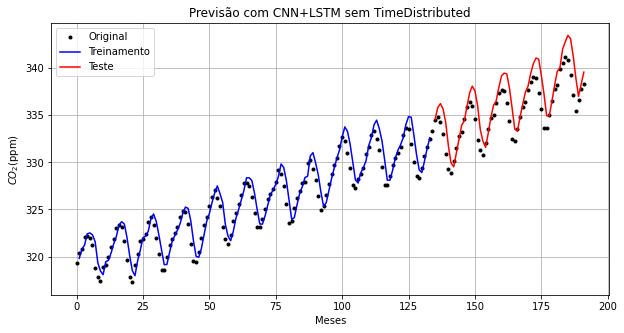

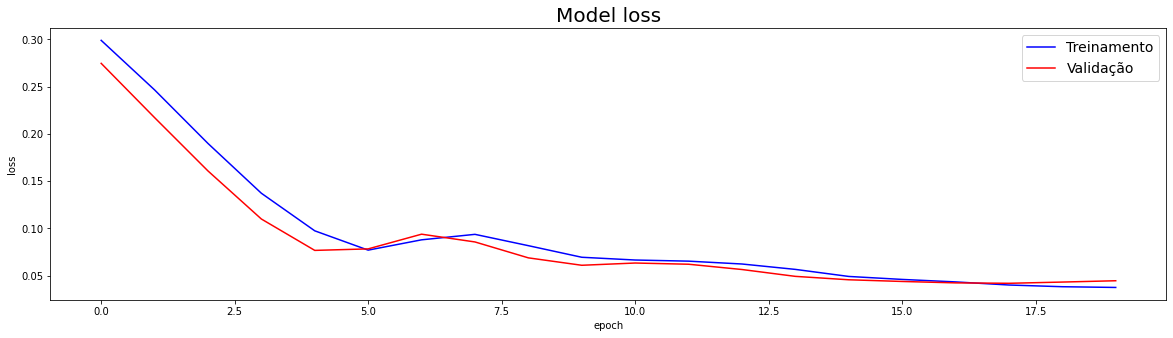

Treinamento: 1.17 RMSE
Teste: 1.36 RMSE


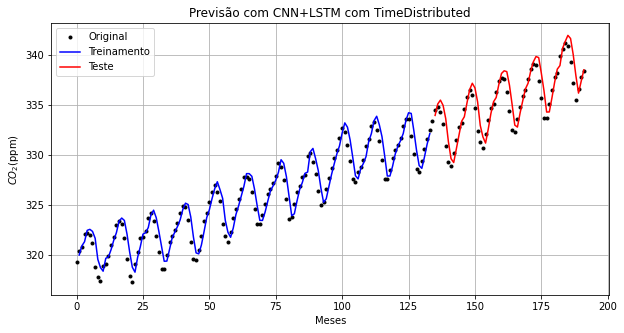

In [ ]:
plot_history_predictions(historySemTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMSemTD, 
                         'Previsão com CNN+LSTM sem TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)

plot_history_predictions(historyTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMTD, 
                         'Previsão com CNN+LSTM com TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)



### Atividade

Neste exercício, vamos construir um preditor de séries temporais e treiná-lo para prever uma única série temporal. Usaremos um conjunto de dados fornecido pelo [UCI Machine Learning Repository] (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) que possui dados de monitoramento da qualidade do ar nas cidades chinesas / distritos. Os dados se referem a concentração de material particulado de diametro menor que 2,5 micrometros (PM2.5), que são as partículas finas inaláveis pelo ser humano e perigosas a saúde. O período de monitoramento é de 01/01/2010 a 31/12/2015. Dados faltantes são denotados como NaN.

Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220 to 10236, [Web Link].


#### Configurando os dados

Começaremos trabalhando com dados de Pequim e filtraremos o conjunto de dados para registros a partir de 2015.




In [ ]:
df_Beijing = pd.read_csv('https://drive.google.com/uc?export=view&id=1CgPjMJuaF7AfayTrzCi4WIAJgJpg7CWN')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [ ]:
# interpolando os dados
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

### A atividade é prever para as próximas 6h o valor da concentração de PM2.5. 

Utilize os conceitos aprendidos até aqui, testando diferentes modelos de IA e diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.

1. Inicialmente, escolha uma estação de monitoramento de uma das cidades com que irá trabalhar, e faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam.
2. Explore as técnicas MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM, utilizando a camada TimeDistributed, quando julgarem necessário;
3. Escolha, com base na avaliação do loss e das métricas MAE, MSE, NMSE, r, R2 e Fac2 qual foi o melhor modelo, apresentando por hora e também na média final das 6h;
4. Use o ano de 2015 para fins de teste;
5. Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor;

Importante1: Para cada 24h de entrega em atraso, serão descontados 25% da nota. <br>
Importante2: O trabalho deve ser feito em **dupla**. <br>
Importante3: BÔNUS! Quem conseguir utilizar as informações meteorológicas para melhorar a qualidade dos modelos finais, ganhará um bônus na nota final; idem para a utilização de wavelets para feature augmentation. <br>

